In [1]:
#config section to run as needed

import sys
sys.path.insert(0, "/lustre/lrspec/metrics")
sys.path.insert(0, "/home/3155/metrics/Multi_Transient_Metrics_Hub")

import os
os.environ["RUBIN_SIM_DATA_DIR"] = "/lustre/lrspec/metrics/rubin_sim_data"

#set the path to your cadence files
db_dir = "/lustre/lrspec/metrics/"

#from dustmaps.config import config
#config.reset()

In [12]:
#imports
%matplotlib inline
import sys
import glob
import os
import random
import json
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from astropy.table import Table
import rubin_sim.maf.db as db
sys.path.append(os.path.abspath(".."))
from local_opsdb_patch import OpsimDatabase #local
from rubin_sim import maf
from rubin_sim.maf.utils import m52snr
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.plots as plots

import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metric_bundles as metric_bundles
from astropy.cosmology import z_at_value
from rubin_sim.maf.metrics import BaseMetric
from rubin_sim.maf.slicers import UserPointsSlicer
from rubin_sim.maf.metric_bundles import MetricBundle, MetricBundleGroup
from rubin_sim.maf.db import ResultsDb
import rubin_sim.maf.utils as maf_utils
import rubin_sim.maf.metrics as metrics
from rubin_sim.maf.plots import HealpixSkyMap
import rubin_sim.maf.plots as plots

#from rubin_sim.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin
from astropy.coordinates import Galactic, ICRS
import astropy.units as u
import healpy as hp
from scipy.stats import truncnorm


from rubin_sim.phot_utils import DustValues

dust_model = DustValues()
#from rubin_sim.utils import getPackageDir
from importlib import resources
import importlib

import shared_utils

def getPackageDir(pkg_name):
    try:
        return resources.files(pkg_name).parent
    except Exception as e:
        raise RuntimeError(f"Could not find package {pkg_name}: {e}")

In [18]:
#metric configurations

metric_filename = "new_names_local_GRBafterglows_metric"

#control whether we generate new files
generate_new_templates = False
generate_new_pop = False
make_debug_plots = True #toggle whether or not the pop generation makes plots

#population variables
rate_density = 1e-8
dmin, dmax = 10, 1000
gal_lat_cut = None #latitude cut, for Galactic phenomena
t_start = 1 #start time in days
t_end = 3652

#cadence variables
cadences = ['four_roll_v4.3.1_10yrs', 'baseline_v4.3.1_10yrs']
ignore_triples = False #turn this to true to ignore triples
filters = ['u', 'g', 'r', 'i', 'z', 'y'] #doesn't work rn i think but
#if we wanted to look at less filters then we would adjust that here

#storage variables - still need to make these neutral to science cases
rate_str = f"rd{rate_density:.0e}".replace("-", "m")  # Example: 1e-8 to rd1e-8
storage_dir = f"GRBafterglows_fixedpop_detectonly/{rate_str}" #renamed from grbs_dir but could be better named
templates_file = "GRBAfterglow_templates.pkl"
pop_file = os.path.join(storage_dir, f"GRB_population_fixedpop_10yr_{rate_str}.pkl")
os.makedirs(storage_dir, exist_ok=True)

In [13]:
#this happens twice because idk why but it only works like that

#import the metric
metric = __import__(metric_filename)

# Reload the module in case it has changed
importlib.reload(metric)

#import the metric
metric = __import__(metric_filename)

# Reload the module in case it has changed
importlib.reload(metric)


<module 'new_names_local_GRBafterglows_metric' from '/home/3155/metrics/Multi_Transient_Metrics_Hub/GRBafterglows/new_names_local_GRBafterglows_metric.py'>

In [19]:
#load and/or generate light curves
if generate_new_templates==True or not os.path.exists(templates_file):
    metric.generate_Templates(save_to=templates_file)
shared_lc_model = metric.LC(load_from=templates_file)

Saved synthetic GRB light curve templates to GRBAfterglow_templates.pkl
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl


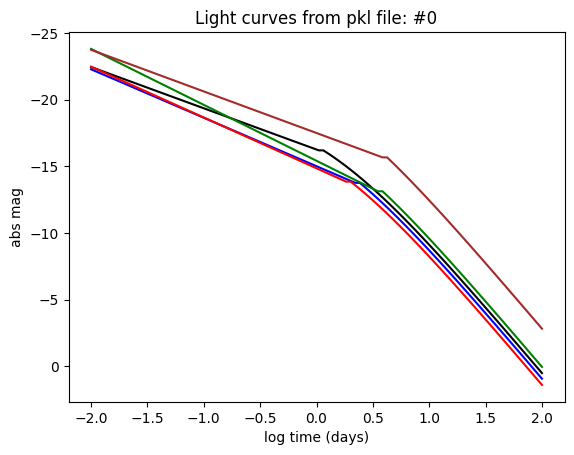

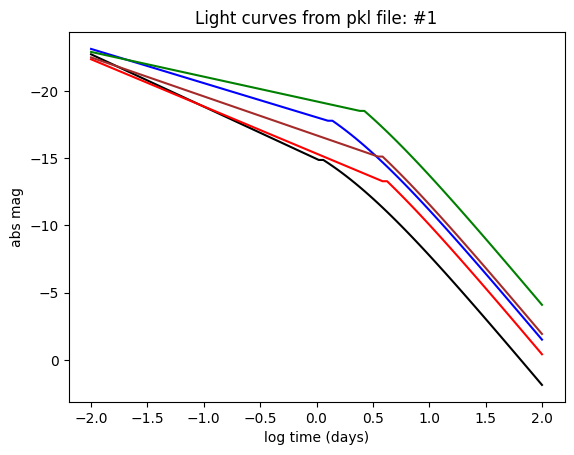

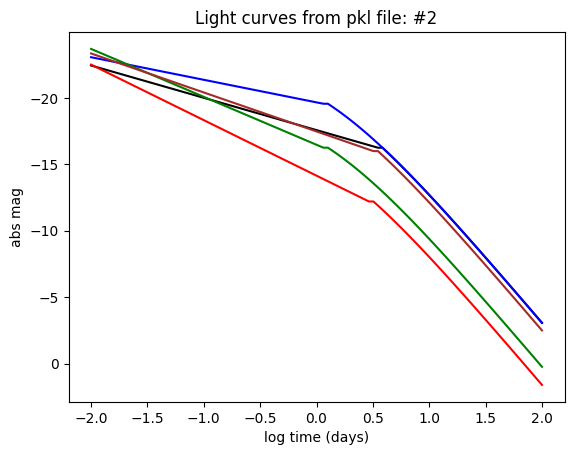

In [20]:
#plot light curves from pkl file if desired
shared_utils.plot_some_lcs_from_pkl(templates_file, num=3)

In [21]:
#population setup

if generate_new_pop==True or not os.path.exists(pop_file):
    slicer = metric.generate_PopSlicer(
        t_start=t_start, t_end=t_end, seed=42,
        d_min=dmin, d_max=dmax, num_lightcurves=1000,
        gal_lat_cut=gal_lat_cut, rate_density=rate_density,
        save_to=pop_file, make_debug_plots=make_debug_plots
    )
else:
    slicer = metric.generate_PopSlicer(load_from=pop_file)

Loaded GRB population from GRBafterglows_fixedpop_detectonly/rd1em08/GRB_population_fixedpop_10yr_rd1em08.pkl


## All 10 years


--- Running four_roll_v4.3.1_10yrs ---
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl

Inspecting one obs_record before saving to CSV:
mjd_obs         | type: <class 'numpy.ndarray'> | length: 754
mag_obs         | type: <class 'numpy.ndarray'> | length: 754
snr_obs         | type: <class 'numpy.ndarray'> | length: 754
filter          | type: <class 'numpy.ndarray'> | length: 754
first_det_mjd   | type: <class 'float'> | value: nan
last_det_mjd    | type: <class 'float'> | value: nan
fade_time_days  | type: <class 'float'> | value: nan
sid             | type: <class 'numpy.int64'> | value: 1
file_indx       | type: <class 'numpy.int64'> | value: 212
ra              | type: <class 'numpy.float64'> | value: 0.6135923151542564
dec             | type: <class 'numpy.float64'> | value: -0.5848608108840141
distance_Mpc    | type: <class 'numpy.float64'> | value: 444.4896553545318
peak_mjd        | type: <class 'numpy.float64'> | value: 64347.14632091699
peak_mag        | type

/home/3155/metrics/Multi_Transient_Metrics_Hub/shared_utils.py:224: UserWarning: Warning: converting a masked element to nan.
  n_filters_detected_per_event = np.array([


Out of 427 simulated events, Rubin detected 26 under the four_roll_v4.3.1_10yrs cadence.
Of those, each event was observed in an average of 1.0 ± 0.0 filters.


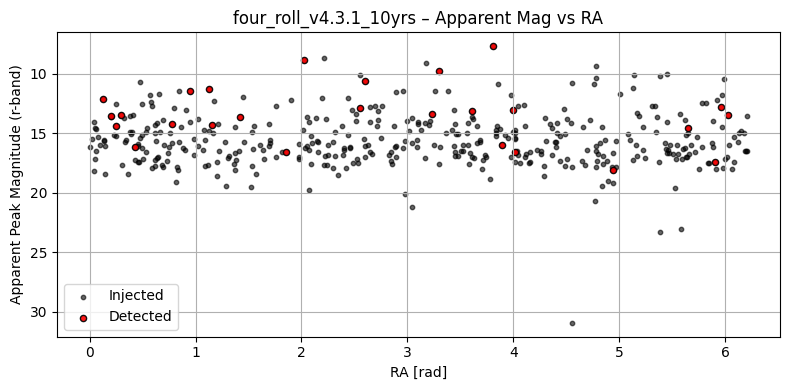

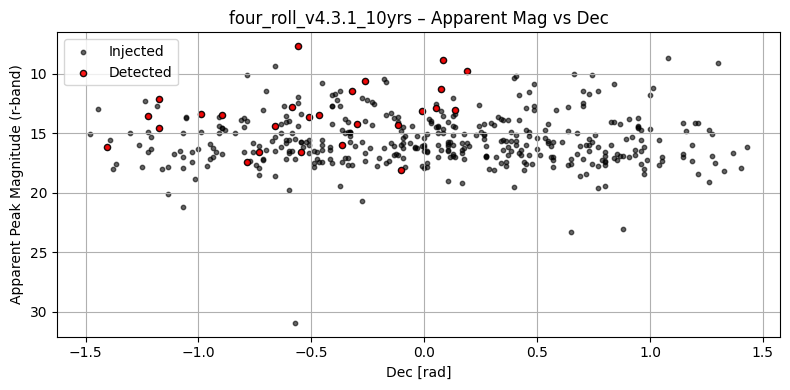

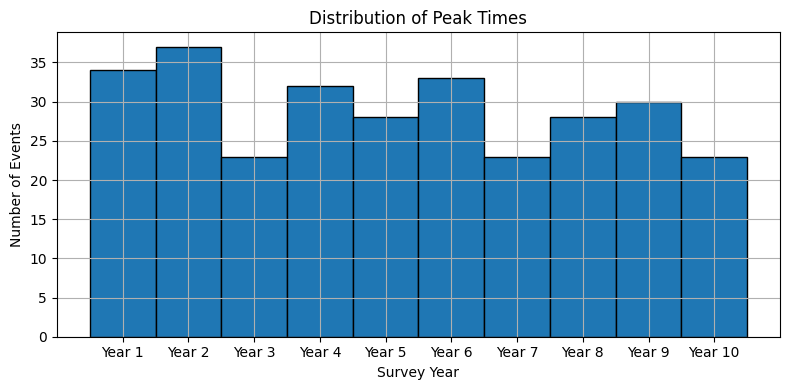

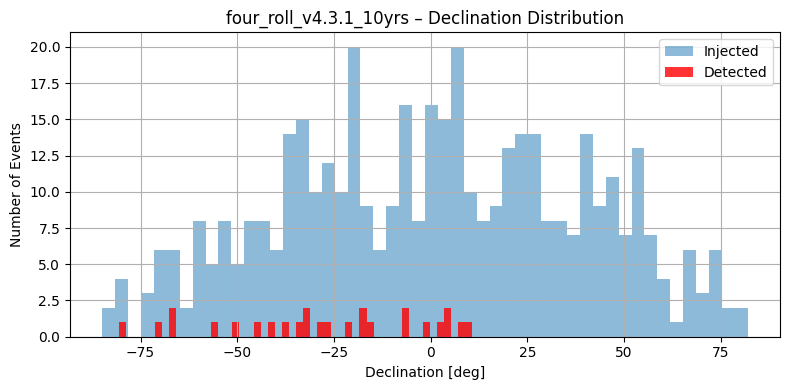


--- Running baseline_v4.3.1_10yrs ---
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl

Inspecting one obs_record before saving to CSV:
mjd_obs         | type: <class 'numpy.ndarray'> | length: 778
mag_obs         | type: <class 'numpy.ndarray'> | length: 778
snr_obs         | type: <class 'numpy.ndarray'> | length: 778
filter          | type: <class 'numpy.ndarray'> | length: 778
first_det_mjd   | type: <class 'float'> | value: nan
last_det_mjd    | type: <class 'float'> | value: nan
fade_time_days  | type: <class 'float'> | value: nan
sid             | type: <class 'numpy.int64'> | value: 1
file_indx       | type: <class 'numpy.int64'> | value: 212
ra              | type: <class 'numpy.float64'> | value: 0.6135923151542564
dec             | type: <class 'numpy.float64'> | value: -0.5848608108840141
distance_Mpc    | type: <class 'numpy.float64'> | value: 444.4896553545318
peak_mjd        | type: <class 'numpy.float64'> | value: 63906.25227580979
peak_mag        | type:

/home/3155/metrics/Multi_Transient_Metrics_Hub/shared_utils.py:224: UserWarning: Warning: converting a masked element to nan.
  n_filters_detected_per_event = np.array([


Out of 427 simulated events, Rubin detected 22 under the baseline_v4.3.1_10yrs cadence.
Of those, each event was observed in an average of 1.0 ± 0.0 filters.


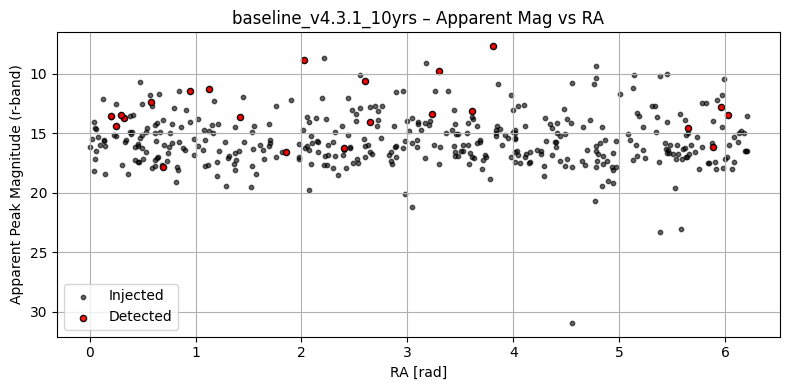

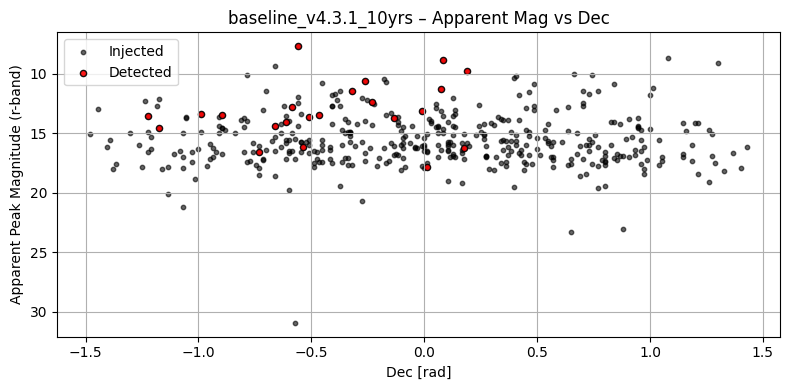

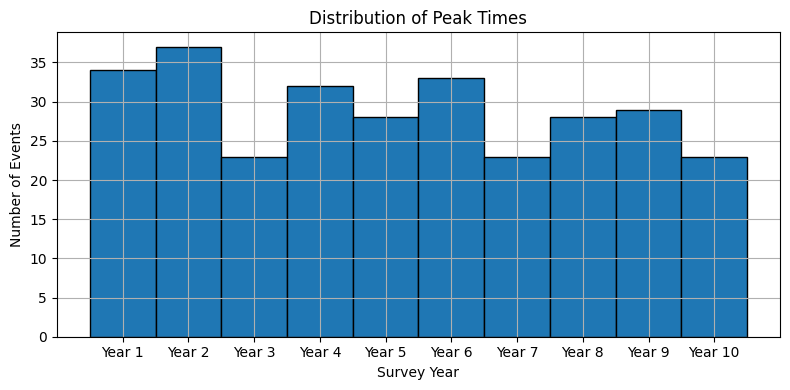

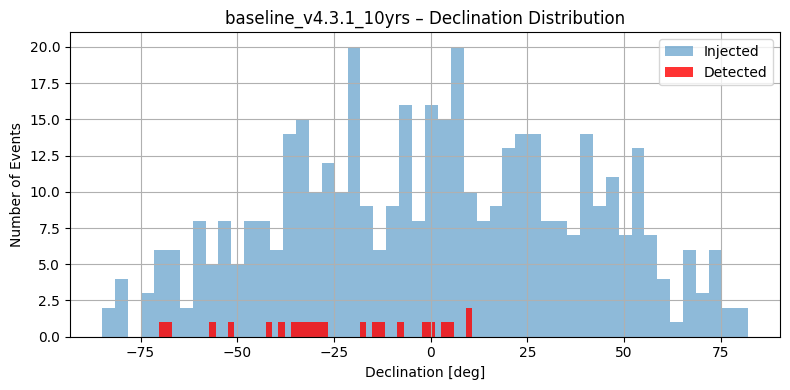

In [25]:
#run detection metric
df_obs_arr = shared_utils.run_detect(metric, slicer, cadences, shared_lc_model, db_dir, storage_dir, debug=True, plot=True)

In [26]:
#choose what to run in run_multi_metrics
multi_metrics = [
    metric.Detect_Metric(lc_model=shared_lc_model),
    metric.GRBAfterglowBetterDetectMetric(lc_model=shared_lc_model),
    metric.GRBAfterglowCharacterizeMetric( lc_model=shared_lc_model),
    metric.GRBAfterglowSpecTriggerableMetric(lc_model=shared_lc_model),
    metric.GRBAfterglowColorEvolveMetric(lc_model=shared_lc_model),
    metric.GRBAfterglowHistoricalMatchMetric(lc_model=shared_lc_model)
]

Loaded GRB afterglow templates from GRBAfterglow_templates.pkl
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl



--- Running four_roll_v4.3.1_10yrs ---


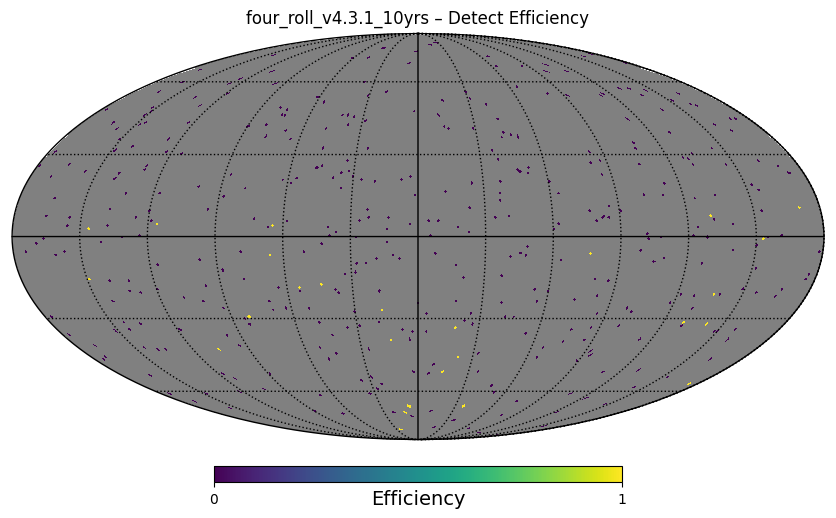

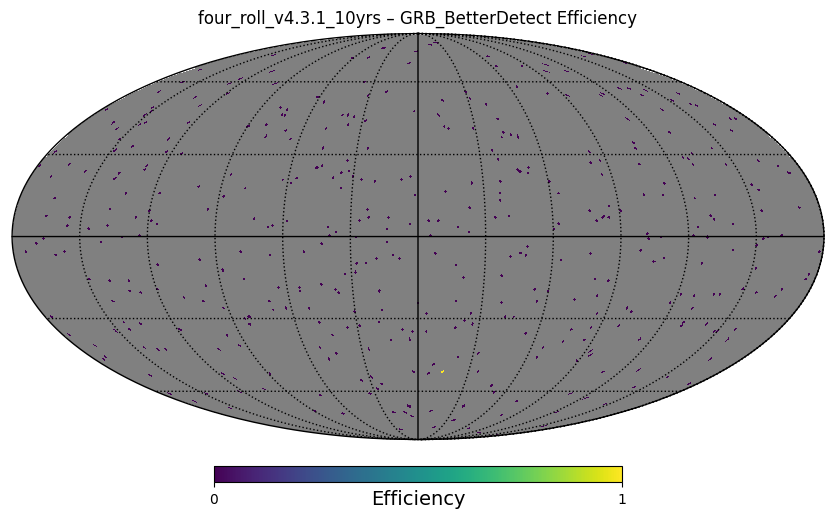

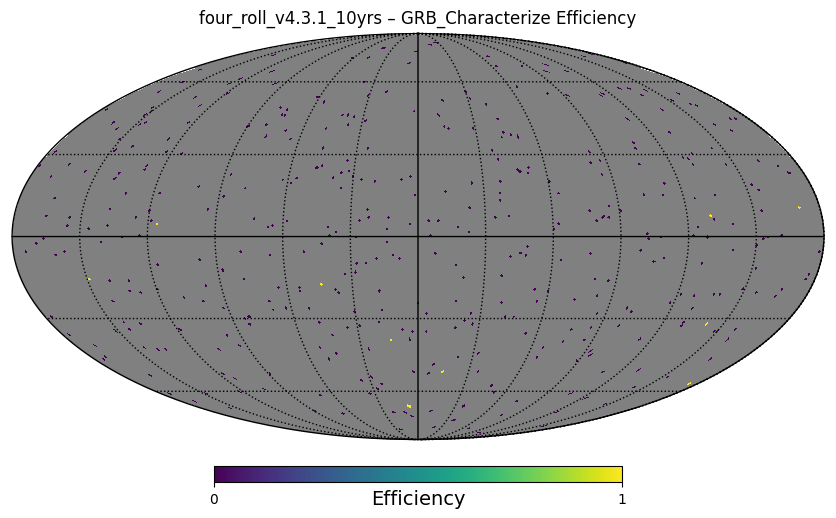

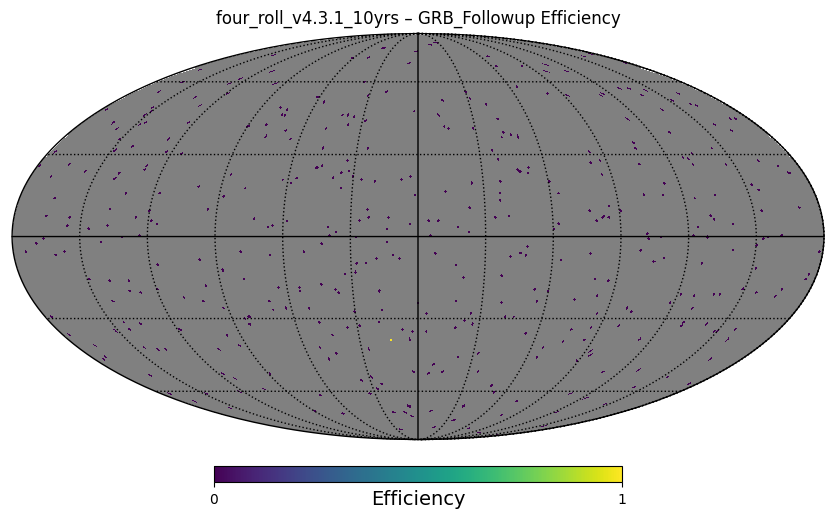

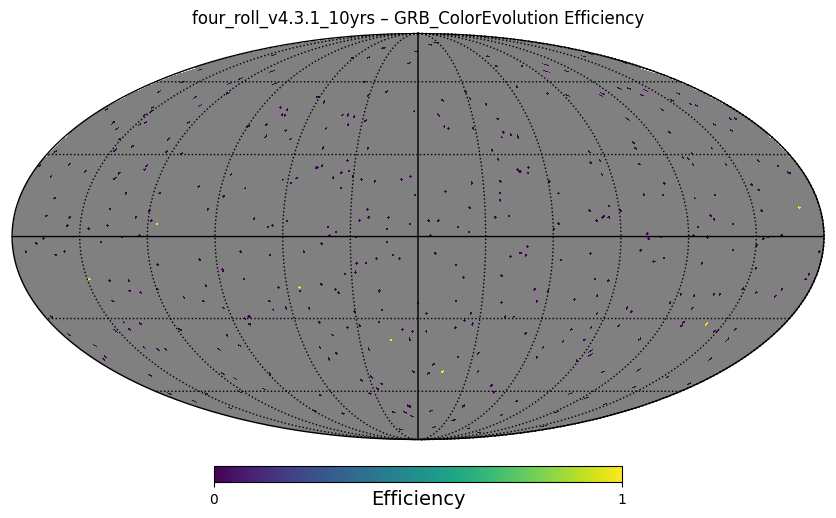

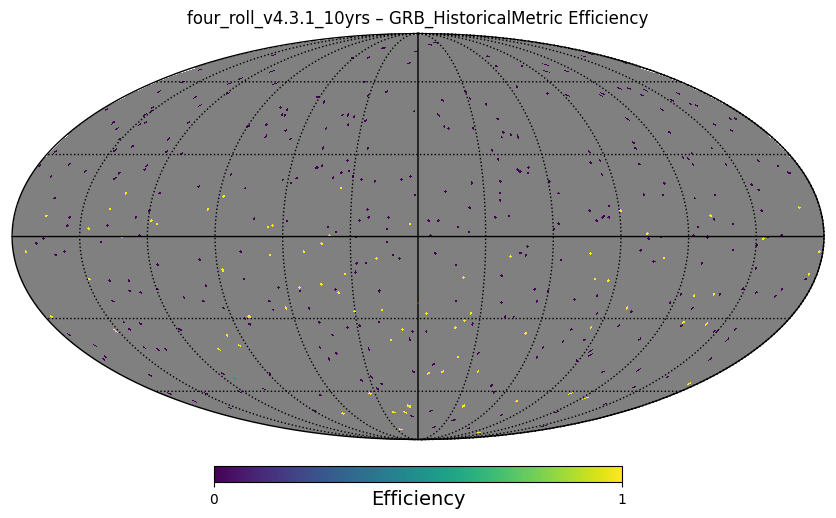


--- Running baseline_v4.3.1_10yrs ---


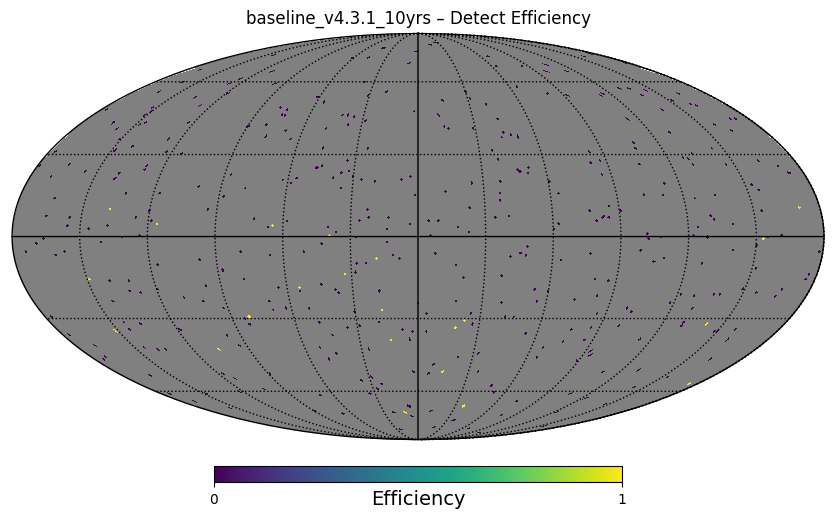

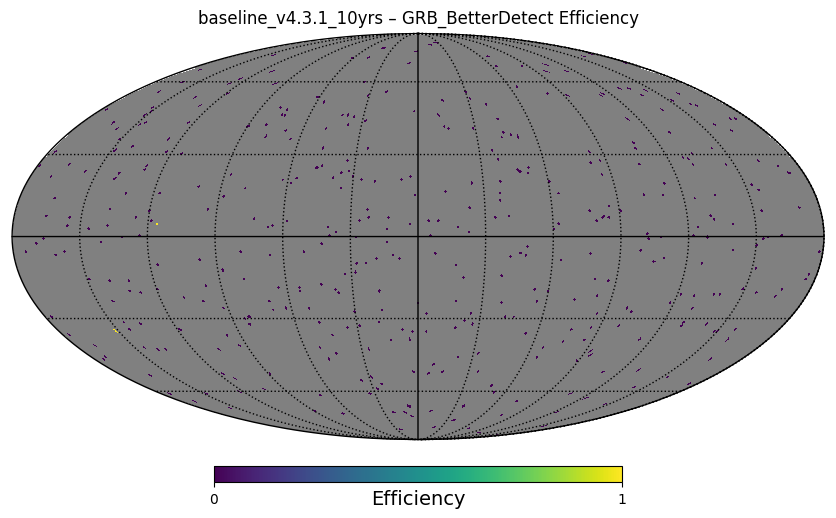

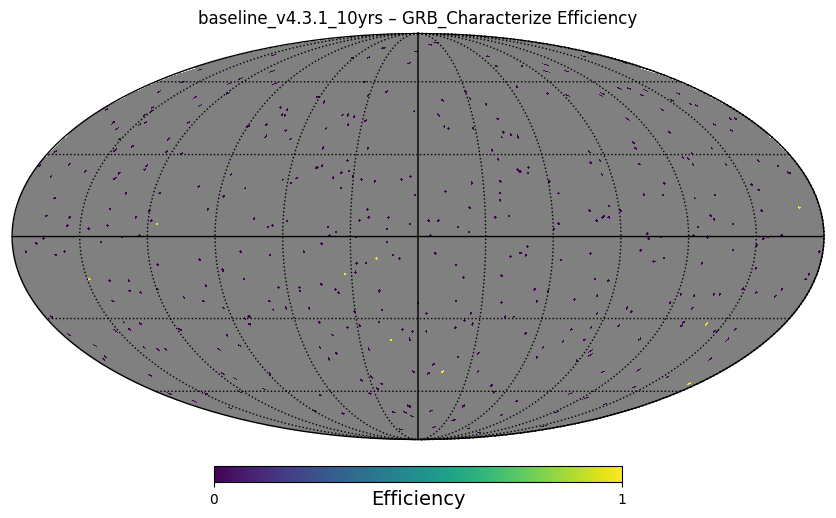

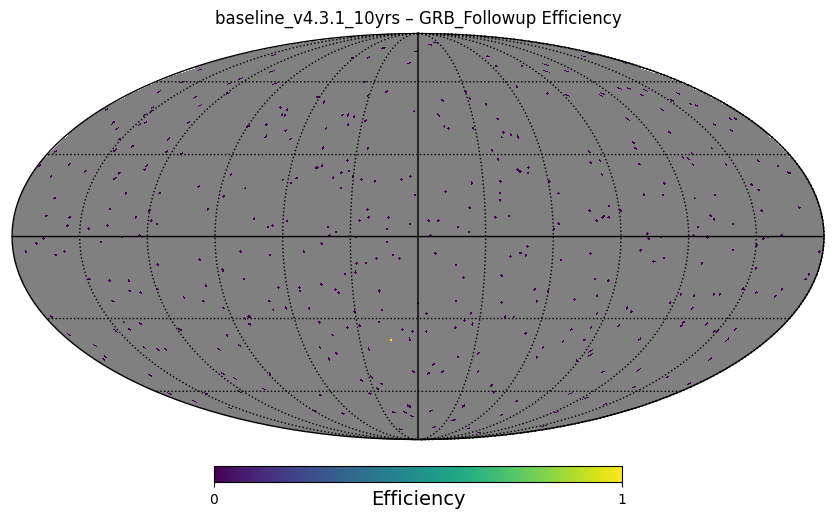

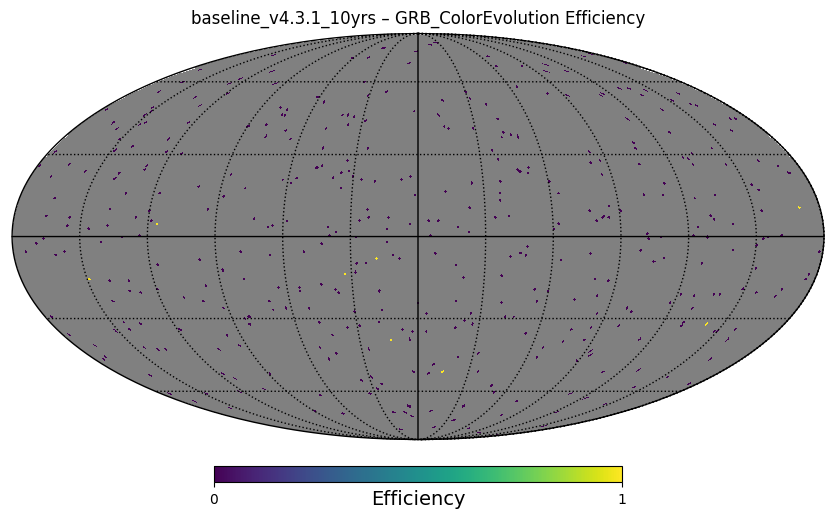

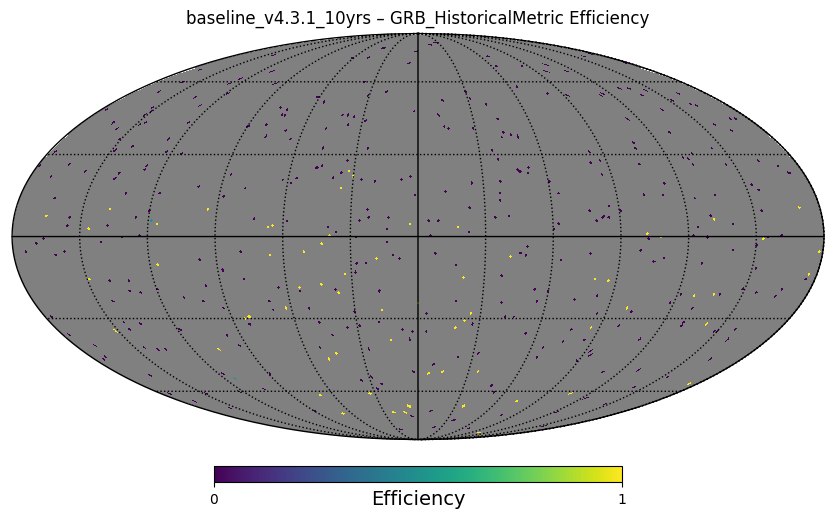

,Sum,run
four_roll_v4.3.1_10yrs_Detect_Metric,26.0,four_roll_v4.3.1_10yrs
four_roll_v4.3.1_10yrs_GRBAfterglowBetterDetectMetric,1.0,four_roll_v4.3.1_10yrs
four_roll_v4.3.1_10yrs_GRBAfterglowCharacterizeMetric,10.0,four_roll_v4.3.1_10yrs
four_roll_v4.3.1_10yrs_GRBAfterglowSpecTriggerableMetric,1.0,four_roll_v4.3.1_10yrs
four_roll_v4.3.1_10yrs_GRBAfterglowColorEvolveMetric,7.0,four_roll_v4.3.1_10yrs
four_roll_v4.3.1_10yrs_GRBAfterglowHistoricalMatchMetric,79.0,four_roll_v4.3.1_10yrs
baseline_v4.3.1_10yrs_Detect_Metric,22.0,baseline_v4.3.1_10yrs
baseline_v4.3.1_10yrs_GRBAfterglowBetterDetectMetric,2.0,baseline_v4.3.1_10yrs
baseline_v4.3.1_10yrs_GRBAfterglowCharacterizeMetric,9.0,baseline_v4.3.1_10yrs
baseline_v4.3.1_10yrs_GRBAfterglowSpecTriggerableMetric,1.0,baseline_v4.3.1_10yrs


In [27]:
shared_utils.run_multi_metrics(multi_metrics, slicer, cadences, shared_lc_model, db_dir, storage_dir, ignore_triples=False, plot=True)

In [221]:
df

,Sum,run
four_roll_v4.3.1_10yrs_Detect_Metric,23.0,four_roll_v4.3.1_10yrs
four_roll_v4.3.1_10yrs_GRBAfterglowBetterDetectMetric,1.0,four_roll_v4.3.1_10yrs
four_roll_v4.3.1_10yrs_GRBAfterglowCharacterizeMetric,8.0,four_roll_v4.3.1_10yrs
four_roll_v4.3.1_10yrs_GRBAfterglowSpecTriggerableMetric,1.0,four_roll_v4.3.1_10yrs
four_roll_v4.3.1_10yrs_GRBAfterglowColorEvolveMetric,8.0,four_roll_v4.3.1_10yrs
four_roll_v4.3.1_10yrs_GRBAfterglowHistoricalMatchMetric,76.0,four_roll_v4.3.1_10yrs
baseline_v4.3.1_10yrs_Detect_Metric,20.0,baseline_v4.3.1_10yrs
baseline_v4.3.1_10yrs_GRBAfterglowBetterDetectMetric,2.0,baseline_v4.3.1_10yrs
baseline_v4.3.1_10yrs_GRBAfterglowCharacterizeMetric,8.0,baseline_v4.3.1_10yrs
baseline_v4.3.1_10yrs_GRBAfterglowSpecTriggerableMetric,1.0,baseline_v4.3.1_10yrs


## Tests

In [ ]:
#Note the new location of the ObsRecord dataframes!!
new_df = pd.read_csv("GRBafterglows_fixedpop_detectonly/rd1em08/Metric_temp_four_roll_v4.3.1_10yrs/ObsRecords_four_roll_v4.3.1_10yrs.csv", converters={'filter': eval})


Text(0.5, 0, 'fade time (days)')

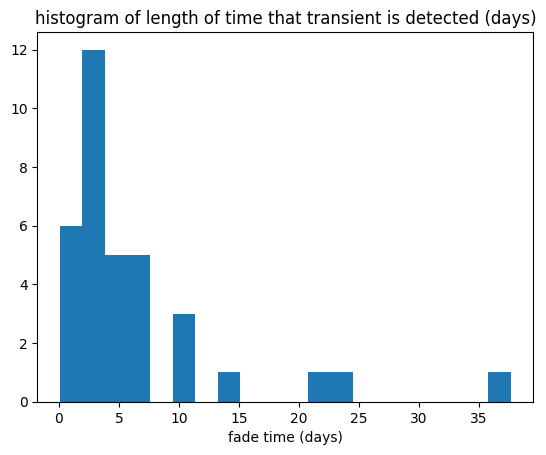

In [222]:
#generally these transients are meant to fade in a few hours

plt.hist(df_obs_arr['fade_time_days'],bins=20)
plt.title("histogram of length of time that transient is detected (days)")
plt.xlabel("fade time (days)")

In [236]:
def plot_observed_light_curve(row, log=True, snr=3):
    '''
    takes a row from an obs dataframe, for instance: detected_df.iloc[4]
    returns nothing
    plots the observed light curve with each filter
    as a random color
    and events with snr>3 are bigger (open circles)
    nondetections are small dots
    '''
    unique_filters = np.unique(row['filter'])
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_filters)))
    filter_to_color = dict(zip(unique_filters, colors))
    color_array = np.array([filter_to_color[f] for f in row['filter']])


    snr_obs_mask = row['snr_obs'] > snr  # change threshold here
    snr_to_marker = {False: '.', True: 'o'}

    # plt.figure(figsize=(10, 6))

    # Loop over each filter and SNR condition
    for snr_cond in [True, False]:
            mask = (snr_obs_mask == snr_cond)
            if np.any(mask):  # Only plot if there are matching points
                if log:
                    plt.scatter(
                        np.log10(row['mjd_obs'][mask]),
                        row['mag_obs'][mask],
                        c=color_array[mask],
                        marker=snr_to_marker[snr_cond]
                    )
                else:
                    plt.scatter(
                        row['mjd_obs'][mask],
                        row['mag_obs'][mask],
                        c=color_array[mask],
                        marker=snr_to_marker[snr_cond]
                    )

    if log:
        plt.xlim(np.log10(row['peak_mjd'] - 10), np.log10(row['peak_mjd'] + 100))
    else:
        plt.xlim(row['peak_mjd'] - 10, row['peak_mjd'] + 100)
    plt.gca().invert_yaxis()
    if log:
        plt.xlabel("log MJD")
    else:
        plt.xlabel("MJD")
    plt.ylabel("Apparent mag")
    plt.title("Light Curve as Observed")
    plt.legend(["Large means detected",
                "Each color is a filter"])
    plt.tight_layout()
    plt.ylim(40,16)
    # plt.xscale("log")
    plt.show()


In [237]:
detected_df = df_obs_arr[df_obs_arr['detected']==True]
print(len(detected_df))

20


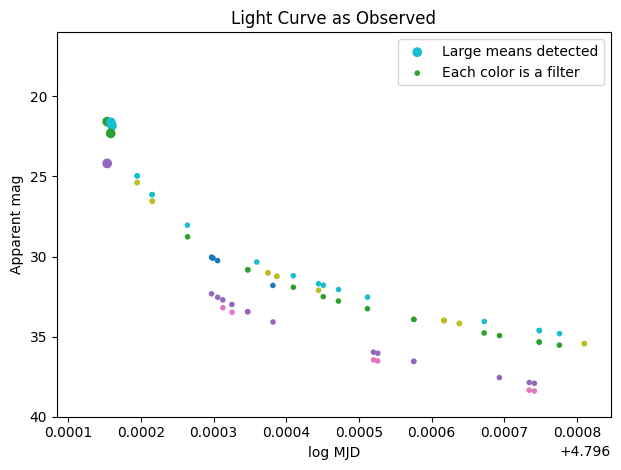

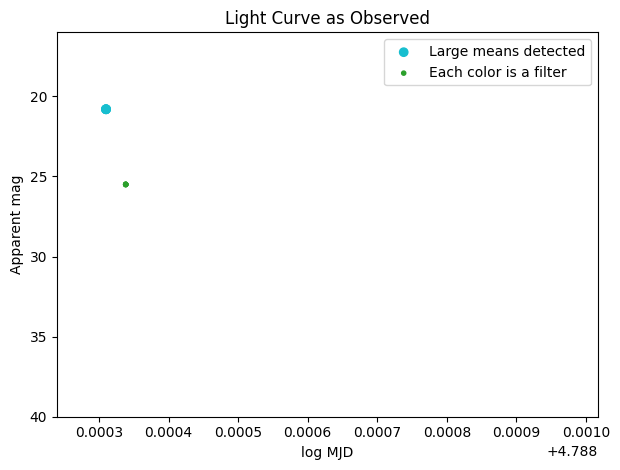

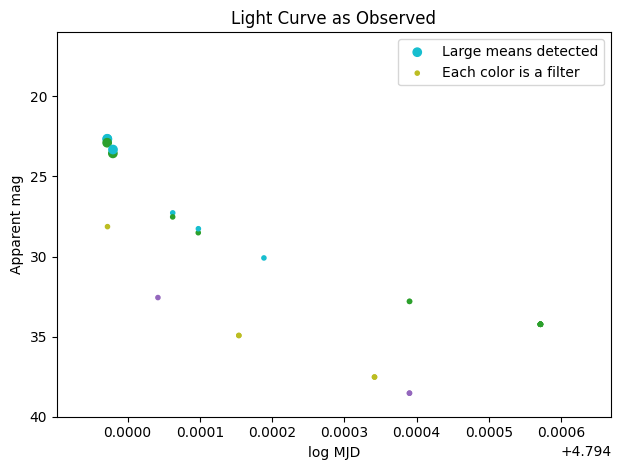

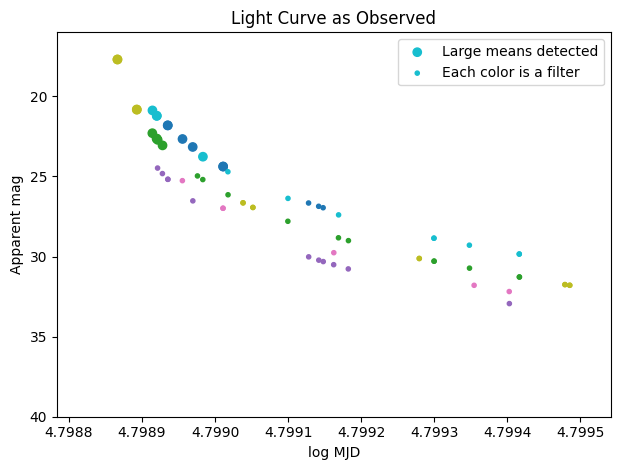

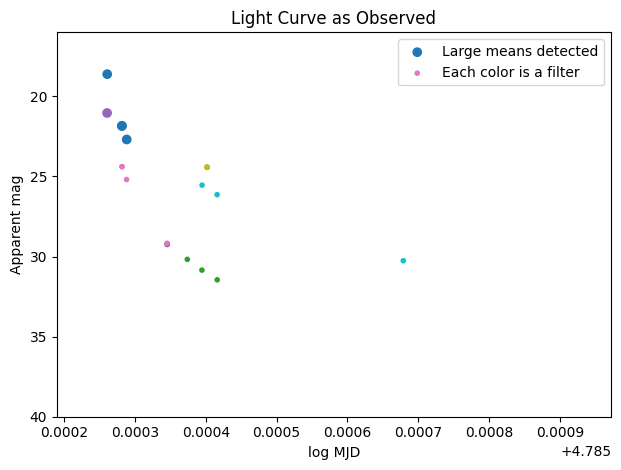

In [238]:
num_plotted=0
for i, row in detected_df.iterrows():
    plot_observed_light_curve(row,log=True)
    if num_plotted>3:
        break
    num_plotted+=1

In [227]:


rates = [estimate_fade_rate(shared_lc_model, i, "r", t1=1.0, t2=10.0) for i in range(len(shared_lc_model.data))]
plt.hist(rates, bins=30)
plt.xlabel("Fade Rate (mag/day)")
plt.ylabel("Number of Light Curves")
plt.title("Empirical Fade Rates from Synthetic GRB Light Curves")
plt.grid(True)
plt.show()

NameError: name 'estimate_fade_rate' is not defined

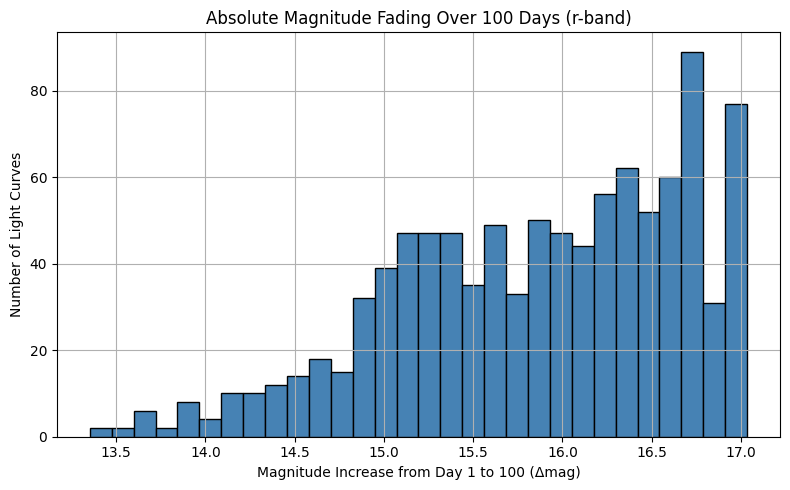

In [235]:
def compute_absolute_fade(lc_model, filtername="r", t1=1.0, t2=100.0):
    """
    Compute Δmag = m(t2) - m(t1) in a given filter for all GRB light curves.
    """
    deltas = []
    for i in range(len(lc_model.data)):
        mag_t1 = np.interp(t1, lc_model.data[i][filtername]['ph'],
                                 lc_model.data[i][filtername]['mag'])
        mag_t2 = np.interp(t2, lc_model.data[i][filtername]['ph'],
                                 lc_model.data[i][filtername]['mag'])
        deltas.append(mag_t2 - mag_t1)
    return np.array(deltas)

delta_mags = compute_absolute_fade(shared_lc_model, filtername='r')

plt.figure(figsize=(8, 5))
plt.hist(delta_mags, bins=30, color='steelblue', edgecolor='black')
plt.xlabel("Magnitude Increase from Day 1 to 100 (Δmag)")
plt.ylabel("Number of Light Curves")
plt.title("Absolute Magnitude Fading Over 100 Days (r-band)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [240]:

# Load the CSV (after fixing how arrays were saved, as discussed)
# df = pd.read_csv("GRBafterglows_output/ObsRecords_four_roll_v4.3.1_10yrs.csv")
new_df = pd.read_csv("GRBafterglows_fixedpop_detectonly/rd1em08/Metric_temp_four_roll_v4.3.1_10yrs/ObsRecords_four_roll_v4.3.1_10yrs.csv", converters={'filter': eval})

# Count how many are detected vs not
detected_counts = new_df['detected'].value_counts()

print("Detection Summary:")
print(detected_counts)

# Optionally print percentages
print("\nDetection Percentages:")
print(detected_counts / len(df) * 100)


Detection Summary:
detected
False    268
True      23
Name: count, dtype: int64

Detection Percentages:
detected
False    92.09622
True      7.90378
Name: count, dtype: float64


In [172]:
print(pd.DataFrame(obs_records).applymap(lambda x: len(x) if hasattr(x, '__len__') and not isinstance(x, str) else 'scalar').nunique()) #


mjd_obs           174
mag_obs           174
snr_obs           174
filter            174
first_det_mjd       1
last_det_mjd        1
rise_time_days      1
fade_time_days      1
sid                 1
file_indx           1
ra                  1
dec                 1
distance_Mpc        1
peak_mjd            1
peak_mag            1
ebv                 1
peak_time           1
detected            1
dtype: int64


/var/folders/tp/cclflcq51yqbq43tdzvfqh_c0000gn/T/ipykernel_87009/929288799.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(pd.DataFrame(obs_records).applymap(lambda x: len(x) if hasattr(x, '__len__') and not isinstance(x, str) else 'scalar').nunique()) #
